# Tutorial 2: Intermediate level
Using esinet to predict single time-frame sources of a sample ERP data set. 

This tutorial is based on an [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html)

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
import os

subjects_dir = mne.datasets.sample.data_path() + '\\subjects'
plot_params = dict(surface='white', hemi='both', verbose=0, subjects_dir=subjects_dir)
mne.set_config('SUBJECTS_DIR', subjects_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data
Just as in the [mne-python tutorial](https://mne.tools/stable/auto_tutorials/inverse/30_mne_dspm_loreta.html) we have to load some sample data first

In [28]:
data_path = mne.datasets.sample.data_path()
raw_fname = os.path.join(data_path, 'MEG', 'sample',
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, verbose=0)  # already has an average reference
events = mne.find_events(raw, stim_channel='STI 014', verbose=0)

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('mag', 'eog'), baseline=baseline, reject=reject,
                    verbose=0)

fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, verbose=0)


epochs_stripped = epochs.copy().load_data().pick_types(meg=True)
fwd = fwd.pick_channels(epochs_stripped.ch_names)
fwd = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                                    use_cps=True, verbose=0)

## Visualize the sample data

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


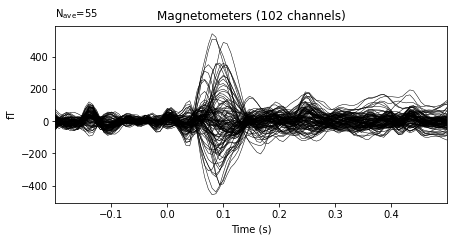

Number of events,72
Events,aud_l: 72
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


In [5]:
epochs.average().plot(verbose=0)
epochs

# Simulate Data
Artificial neural networks need training data to learn how to predict brain-electric activity (sources) given the M/EEG data. 

First, we calculate the signal to noise ratio (SNR) of our EEG data so we can adjust our simulations to it. 

In [3]:
target_snr = util.calc_snr_range(epochs, baseline_span=(-0.2, 0.0), data_span=(0.05, 0.2))
print(f'The target SNR ranges from {target_snr[0]:.2f} to {target_snr[1]:.2f}')

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
The target SNR ranges from 0.88 to 14.34


Next, we can perform the simulations with the packages default settings. Change n_samples to a smaller integer in case this cell runs for too long.

In [4]:
settings = dict(duration_of_trial=0, target_snr=target_snr, n_sources=(1, 10), extents=(2, 40),)
n_samples = 10000
simulation = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation.simulate(n_samples=n_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

Converting Source Data to mne.SourceEstimate object

Create EEG trials with noise...


  0%|          | 0/10000 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...


c:\Users\lukas\Dokumente\projects\esinet\tutorials\..\esinet\util\util.py:99: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference('average', projection=True, verbose=0)


## Visualize the simulated data
Let's visualize the simulated data and see if it looks alright. You can change the idx to another integer to visualize a different sample

In [8]:
%matplotlib qt
idx = 0

simulation.eeg_data[idx].average().plot_topomap([0.])
simulation.source_data.plot(**plot_params, initial_time=simulation.source_data.times[idx], time_viewer=False)

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


# Train the Neural Network
The Net class contains our neural network.

Using the simulations created above, we can train the neural network. This may take several minutes if you are using a CPU and less than a minute if you're using a GPU.

In [5]:
net = Net(fwd, verbose=1)  # Initialize the Net object
net.fit(simulation)  # Train the net using our simulated eeg and source data.

Model: "net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               13184     
_________________________________________________________________
dense_1 (Dense)              (None, 7498)              967242    
Total params: 980,426
Trainable params: 980,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 [==============================] - 3s 43ms/step - loss: 0.0026 - mean_squared_error: 0.0059 - val_loss: 0.0026 - val_mean_squared_error: 0.0061
Epoch 2/100
71/71 [==============================] - 3s 41ms/step - loss: 0.0025 - mean_squared_error: 0.0058 - val_loss: 0.0026 - val_mean_squared_error: 0.0059
Epoch 3/100
71/71 [==============================] - 3s 42ms/step - loss: 0.0025 - mean_squared_error: 0.0056 - val_loss: 0.0026 - val_mean_squared_error: 0.0058
Epoch 4/100
71/71 [==============

# Evaluate the ANN
The evaluation is a two-step procedure. First, we simulate some test data which the neural network has not seen yet. Then we perform predicions on this data and visually examine the results.

In [12]:
settings = dict(duration_of_trial=1, target_snr=target_snr, n_sources=(1, 10), extents=(2, 40),)
n_samples = 8
simulation_test = Simulation(fwd, epochs.info, settings=settings, verbose=True)
simulation_test.simulate(n_samples=n_samples)


# Predict source from EEG
source_hat = net.predict(simulation_test)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]


Create EEG trials with noise...


  0%|          | 0/8 [00:00<?, ?it/s]


Convert EEG matrices to a single instance of mne.Epochs...


c:\Users\lukas\Dokumente\projects\esinet\tutorials\..\esinet\util\util.py:99: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference('average', projection=True, verbose=0)
C:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Visualize a sample

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


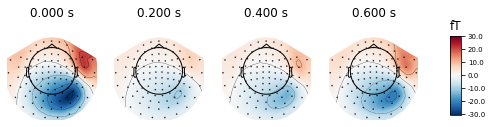

  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [1.21954436e-13 2.26438177e-12 1.64899891e-09]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [0.00000000e+00 0.00000000e+00 3.69435733e-10]


In [13]:
%matplotlib qt

# Ground Truth
idx = 2
source = simulation_test.source_data[idx]
# Plot Source
a = source.plot(**plot_params)
# Plot EEG
evoked = simulation_test.eeg_data[idx].average()
evoked.plot()
evoked.plot_topomap([0.0, 0.2, 0.4, 0.6])


# Plot Prediction
b = source_hat[idx].plot(**plot_params)
# Plot predicted EEG
evoked_hat = util.get_eeg_from_source(source_hat[idx], fwd, epochs_stripped.info, tmin=-0.2)
evoked_hat.plot()
evoked_hat.plot_topomap([0.0, 0.2, 0.4, 0.6])

# Estimate sources from real data
Using ANN

In [18]:
stc = net.predict(epochs.average())
stc.plot(**plot_params)

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


C:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


...using eLORETA

In [39]:
# raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
# events = mne.find_events(raw, stim_channel='STI 014')

# event_id = dict(aud_l=1)  # event trigger and conditions
# tmin = -0.2  # start of each epoch (200ms before the trigger)
# tmax = 0.5  # end of each epoch (500ms after the trigger)
# raw.info['bads'] = ['MEG 2443', 'EEG 053']
# baseline = (None, 0)  # means from the first instant to t = 0
# reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

# epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
#                     picks=('meg', 'eog'), baseline=baseline, reject=reject)
# evoked = epochs.average().pick('meg')
# fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
# fwd = mne.read_forward_solution(fname_fwd)



method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)

inverse_operator = mne.minimum_norm.make_inverse_operator(
    epochs.info, fwd, noise_cov, loose='auto', depth=None, fixed=True)
    
stc_elor, residual = mne.minimum_norm.apply_inverse(epochs.average(), inverse_operator, lambda2,
                              method=method, return_residual=True, verbose=True)
stc_elor.plot(**plot_params)


Computing rank from data with rank=None
    Using tolerance 9.4e-10 (2.2e-16 eps * 102 dim * 4.1e+04  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 3)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 102 -> 99
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 1705
log-likelihood on unseen data (descending order):
   shrunk: -524.951
   empirical: -525.058
selecting best estimator: shrunk
[done]
Computing inverse operator with 102 channels.
    102 out of 102 channels remain after picking
Selected 102 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 2.3e-14 (2.2e-16 eps * 102 dim * 1  max singular value)
    Estimated 

  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [4.41159236e-11 5.05279221e-11 9.08353016e-11]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [1.75879811e-10 2.06670461e-10 3.82826427e-10]


  File "C:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\_brain\_brain.py", line 1348, in _on_button_release
    self.picked_renderer = self.plotter.iren.FindPokedRenderer(x, y)
AttributeError: 'RenderWindowInteractor' object has no attribute 'FindPokedRenderer'


Using control points [2.25497920e-10 2.60908665e-10 4.26376646e-10]


In [ ]:
epochs.average().plot()
epochs.average().plot_topomap([0.087, 0.1])

In [ ]:
fwd_stripped = fwd.copy().pick_channels(epochs.copy().pick_types(meg=True).ch_names)

def select_channels_of_forward_model(fwd, info):
    return fwd.copy().pick_channels(epochs.copy().pick(info.ch_names).ch_names)

In [53]:
simulation_test.eeg_data[0]._data.shape

(1, 102, 150)

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


C:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


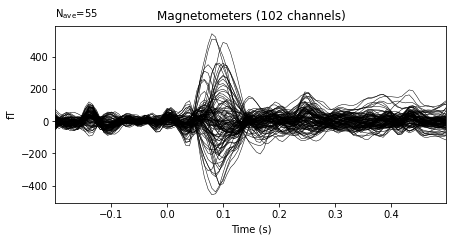

In [58]:
# evoked = epochs.average()

# stc = net.predict(evoked)
# evoked_hat = util.get_eeg_from_source(stc, fwd, epochs_stripped.info, tmin=-0.2)


evoked.plot()

plt.figure()
plt.plot(evoked.times, np.std(evoked.data, axis=0))

# evoked_hat.plot()
# evoked_hat.plot_topomap([0.0, 0.2, 0.4, 0.6])


# plt.figure()
# plt.plot(evoked_hat.times, np.std(stc.data, axis=0))

# evoked_hat.plot()
# evoked_hat.plot_topomap([0.0, 0.2, 0.4, 0.6])